In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.io import loadmat
from numba import njit
from sklearn.preprocessing import OneHotEncoder

In [4]:
matdata = loadmat('Data/Lab 4/ex4data1.mat')
weights = loadmat('Data/Lab 4/ex4weights.mat')

In [7]:
Θ1 = weights['Theta1']
Θ2 = weights['Theta2']

Θ = tuple([Θ1, Θ2])
print(Θ1.shape, Θ2.shape)

X, Y = matdata['X'], matdata['y']
Y = Y.reshape(len(X))
print(X.shape, Y.shape)

encoder = OneHotEncoder(categories='auto')
Y_OH = encoder.fit_transform(matdata['y']).toarray()
print(Y_OH.shape)

(25, 401) (10, 26)
(5000, 400) (5000,)
(5000, 10)


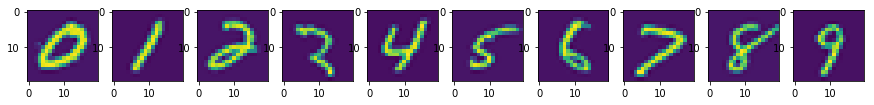

In [8]:
DIG_MAP = { digit: y_val for digit, y_val in zip(range(10), Y[::500]) }
IMGAGES = matdata['X'].reshape(len(X), 20, 20)

fig, axs = plt.subplots(1, 10, figsize=(15,15))
for digit in sorted(DIG_MAP):
    start, end = digit*500, (digit+1)*500
    img = IMGAGES[start:end][50]
    axs[digit].imshow(img.T)

In [9]:
@njit
def activation_func(z):
    """ 
        Parameters
        ----------
        z: array, shape (any)
        
        Returns
        -------
        g(z): array, shape (any)
    """
    return 1 / (1 + np.exp(-z))


@njit
def get_a_out(θ, a_in):
    """ 
        Parameters
        ----------
        θ:    array, shape (n_out, n_in)
        a_in: array, shape (n_in, )
        
        Returns
        -------
        a_out: array, shape (n_out)
    """
    return activation_func(θ.dot(a_in))


@njit
def h_func(Θ, x):
    """

        Parameters
        ----------
        Θ: tuple of Θ matrix
        x: array, shape (n_in, )
        
        Returns
        -------
        h(Θ, x): array, shape (n_out)
    """
    a_zero = np.ones(1)
    a_in = x
    for i in range(len(Θ)):
        a_in = np.concatenate((a_zero, a_in))
        a_in = get_a_out(Θ[i], a_in)
    return a_in


@njit
def cost_func(Θ, x, y):
    """
        Parameters
        ----------
        Θ: array of Θ matrix
        x: array, shape (n_in, )
        y: array, shape (n_categories, )
        
        Returns
        -------
        cost: array, shape (n_out)
    """
    h_Θx = h_func(Θ, x)
    return (y*np.log(h_Θx) + (1-y)*np.log(1-h_Θx)).sum()


@njit
def J_func(Θ, x, y, λ):
    """
        Parameters
        ----------
        Θ: tuple of Θ matrix
        x: array, shape (m, n)
        y: array, shape (m, )
        λ: number
        
        Returns
        -------
        J(Θ): number
    """
    m = len(x)
    N_L = len(Θ)
    
    J_value = -np.array([cost_func(Θ, x[i], y[i]) for i in range(m)]).mean()
    
    L2 = 0
    if λ != 0:
        for i in range(len(Θ)):
            L2 += (Θ[i]**2).sum()
        L2 *= λ/(2*m)
    
    return J_value + L2

In [10]:
def forward_propagation(Θ, x):
    """
        Parameters
        ----------
        Θ: array of Θ matrix
        x: array, shape (n_in, )
        
        Returns
        -------
        a: List[np.array], shape (n_out, n_in)
    """
    N_L = len(Θ)
    
    a_zero = np.ones(1)
    a = [None] * (N_L + 1)

    a_in = x
    for i in range(N_L):
        a_in = np.concatenate((a_zero, a_in))
        a[i] = a_in
        a_out = get_a_out(Θ[i], a_in)
        a_in = a_out

    a[-1] =  a_out   
    return a  


def back_propagation(Θ, x, y, *, λ):
    """
        Parameters
        ----------
        Θ: tuple of Θ matrix
        x: array, shape (m, n)
        y: array, shape (m, n_categories)
        
        Returns
        -------
        D: array, shape == Θ[i].shape
    """
    m = len(x)
    N_L = len(Θ) + 1

    Δ = np.array([np.zeros(θ.shape) for θ in Θ])
    D = np.array([np.zeros(θ.shape) for θ in Θ])
    
    for t in range(0, m):
        a = forward_propagation(Θ, x[t])
        
        δ = [None] * N_L
        δ[N_L-1] = a[N_L-1] - y[t]
        
        for l in range(N_L-2, 0, -1):
            δ[l] = Θ[l].T.dot(δ[l+1]) * a[l]*(1-a[l])
    
        for l, _ in enumerate(Δ):
            delta = δ[l+1]
            if l != len(Δ) - 1:
                delta = delta[1:]
            delta = np.vstack(delta)
            al = np.vstack(a[l]).T
            Δ[l] +=  delta.dot(al)
            
    for l, _ in enumerate(Δ):
        for (i, j), Δlij in np.ndenumerate(Δ[l]):
            if j != 0:
                D[l][i, j] = (Δlij + λ*Θ[l][i, j]) / m
            else:
                D[l][i, j] = Δlij / m        
    return D


def to_number(h_array):
    """ 
        Parameters
        ----------
        h: array, shape (Θ[-1].n_out, )
        
        Returns
        -------
        number: 0, 1, .. 8, 9
    """
    return h_array.argmax() + 1


def accuracy(actual_y, expected_y):
    stat = Counter(actual_y == expected_y)
    return stat[True] / (stat[True] + stat[False])


def gradient_check(Θ, x, y, *, λ, ϵ):
    """
        Parameters
        ----------
        Θ: tuple of Θ matrix
        x: array, shape (m, n)
        y: array, shape (m, n_categories)
        λ: number
        ϵ: number
        
        Returns
        -------
        D: array, shape == Θ[i].shape
    """
    D_expected = np.array([np.zeros(θ.shape) for θ in Θ])
    for l, _ in enumerate(Θ):
        for (i, j), Θlij in np.ndenumerate(Θ[l]):
            theta = Θ[l][i, j]
            
            Θ[l][i, j] = theta + ϵ
            J_plus = J_func(Θ, x, y, λ)

            Θ[l][i, j] = theta - ϵ
            J_minus = J_func(Θ, x, y, λ)
            
            D_expected[l][i,j] = (J_plus - J_minus) / (2*ϵ)
            
            Θ[l][i][j] = theta
    return D_expected


def gradient_descent(Θ, x, y, *, λ, ϵ, α):
    """
        Parameters
        ----------
        Θ: tuple of Θ matrix
        x: array, shape (m, n)
        y: array, shape (m, n_categories)
        λ: number
        ϵ: number
        
        Returns
        -------
        Θ: tuple of Θ matrix
    """
    N_L = len(Θ)
    
    for i in range(160):
#         print(i, 'α = ', α)
        D = back_propagation(Θ, x, y, λ=λ)
        Θ_new = tuple(Θ[i] - α*D[i] for i in range(N_L))

        J_Θ = J_func(Θ, x, y, λ)
        J_Θ_new = J_func(Θ_new, x, y, λ)
        ΔJ = J_Θ - J_Θ_new
        if ΔJ < 0:
#             print("ΔJ < 0")
            α /= 3
            continue
        elif ΔJ < ϵ:
            print("ΔJ < ϵ")
            break
        elif ΔJ < 10**(-2):
            α *= 3
#             print("ΔJ < 0.01")
            
        Θ = Θ_new

    print(i)
    return Θ

In [11]:
y = np.array([
    to_number(h_func(Θ, x))
    for x in X
])
accuracy(y, Y)

<ipython-input-9-82c0be355d55>:47: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  a_in = get_a_out(Θ[i], a_in)


0.9752

In [8]:
ϵ = 10**(-8)
λ = 0
Θ_rand = tuple(np.random.rand(*θ.shape)*0.24 - 0.12 for θ in Θ)

In [9]:
%%time
Θ_new = gradient_descent(Θ_rand, X, Y_OH, λ=λ, ϵ=ϵ, α=3)

<ipython-input-5-82c0be355d55>:85: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  J_value = -np.array([cost_func(Θ, x[i], y[i]) for i in range(m)]).mean()


159
CPU times: user 15min 7s, sys: 4.72 s, total: 15min 12s
Wall time: 15min 19s


In [10]:
accuracy(np.array([to_number(h_func(Θ_new, x)) for x in X]), Y)

0.9118

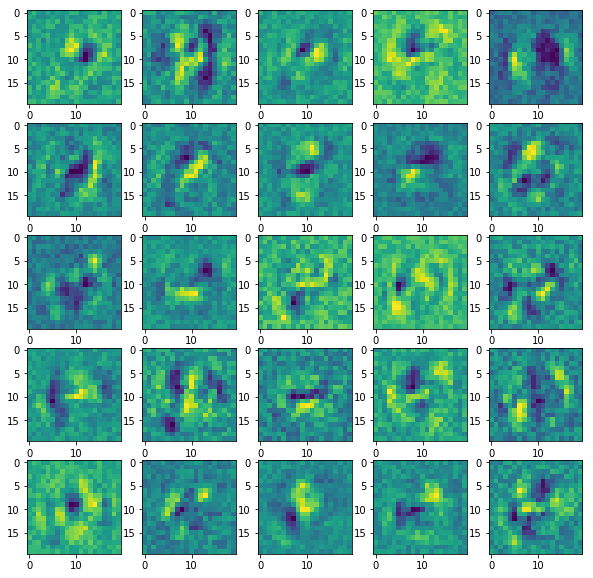

In [11]:
from itertools import product

fig, axs = plt.subplots(5, 5, figsize=(10,10))
idxs = product(range(5), range(5))
        
for idx in idxs:
    i0, i1 = idx
    i = 5 * i0 + i1
    img = Θ_new[0][i][1:].reshape(20, 20)
    axs[i0][i1].imshow(img)

In [12]:
from typing import NamedTuple
from pprint import pprint

class Error(NamedTuple):
    l: int
    i: int
    j: int
    D_backpropag: float
    D_aproximate: float

ϵ = 1e-4
Θ_rand = tuple(np.random.rand(*θ.shape)*0.24 - 0.12 for θ in Θ)
D = back_propagation(Θ_rand, X, Y_OH, λ=0)
D_expected = gradient_check(Θ_rand, X, Y_OH, λ=0, ϵ=ϵ)

<ipython-input-9-82c0be355d55>:85: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  J_value = -np.array([cost_func(Θ, x[i], y[i]) for i in range(m)]).mean()


In [13]:
errors = []
for l, _ in enumerate(D):
    for (i, j), _ in np.ndenumerate(D[l]):
        if j == 0: 
            continue
        if abs(D[l][i, j] - D_expected[l][i, j]) >= 1e-3:
            err = Error(l, i, j, D[l][i, j],  D_expected[l][i, j])
            errors.append(err)
pprint(errors)

[]
